In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.sans-serif'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.autolayout'] = True

# 資料讀取與前處理

In [3]:
columns = ['ID', 'Lon', 'Lat', 'EL', 'Name']
stn = pd.read_table('StnList.txt', names=columns, encoding='Big5')
columns = ['Time']
columns.extend(stn['Name'].to_list())
Temp = pd.read_fwf('HW4_Temp.txt', names=columns, index_col='Time')
Temp.index = pd.to_datetime((Temp.index-1).astype('str'), format='%Y%m%d%H')

In [4]:
# Fill missing data
Temp = Temp.replace('****', np.nan).astype('float').interpolate(axis=0)

In [5]:
# Remove data on Feb. 29
Feb29idx = Temp[(Temp.index.month==2)&(Temp.index.day==29)].index
Temp = Temp.drop(labels=Feb29idx)

# 第一題

## 第A & B小題

In [6]:
# Mean Temp. of each station
stnMean = Temp.mean()
# Mean Temp. anomaly series of 19 stns
MeanTA = Temp.sub(stnMean).mean(axis=1)

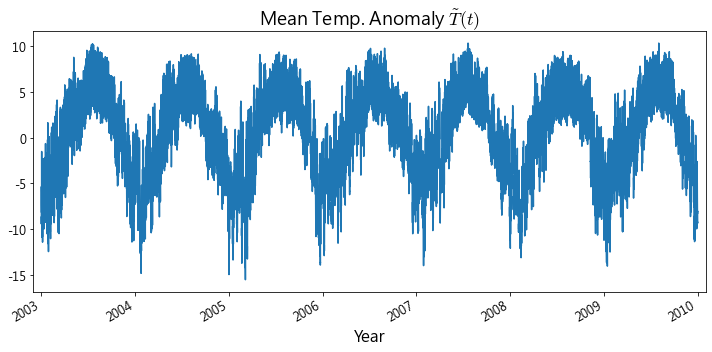

In [7]:
plt.figure(figsize=(10,5))
plt.title(r'Mean Temp. Anomaly $\tilde{T}(t)$')
MeanTA.plot()
plt.xlim('2002-12-01 00', '2010-01-31 23')
plt.xlabel('Year')
plt.savefig('Figure1-A-1.png', dpi=360)

## 第C小題

In [8]:
def FourierSeries(t, p, k):
    n = t.shape[0]
    fs = np.zeros((2*k,n))
    for i in range(k):
        fs[2*i]   = np.sin(2*(i+1)*np.pi*t/p)
        fs[2*i+1] = np.cos(2*(i+1)*np.pi*t/p)
    return fs

def pred(x, b):
    n = x.shape[0]
    y_hat = 0
    for i in range(n):
        y_hat = y_hat + b[i]*x[i]
    return y_hat

In [9]:
idx = np.linspace(1, 7*365*24, 7*365*24)
fourier1 = FourierSeries(idx, p=8760, k=182)
fourier2 = FourierSeries(idx, p=24, k=12)
fourier = np.concatenate((fourier1, fourier2))

In [10]:
# Annual Periodicity p = 8760 hr
mTau = MeanTA.values.reshape((7, 365*24)).mean(axis=0)
mu = mTau.mean()
a1 = np.zeros((182,))
b1 = np.zeros((182,))
p = 8760
for i in range(182):
    for j in range(p):
        a1[i] = a1[i] + 2/p * mTau[j]*np.sin(2*(i+1)*np.pi*(j+1)/p)
        b1[i] = b1[i] + 2/p * mTau[j]*np.cos(2*(i+1)*np.pi*(j+1)/p)

In [11]:
# Diurnal Periodicity p = 24 hr
mTau = np.zeros((24,))
for i in range(24):
    mTau[i] = MeanTA[MeanTA.index.hour==i].mean()

a2 = np.zeros((12,))
b2 = np.zeros((12,))
p = 24
for i in range(12):
    for j in range(24):
        if i < 11:
            a2[i] = a2[i] + 2/p * mTau[j]*np.sin(2*(i+1)*np.pi*(j+1)/p)
            b2[i] = b2[i] + 2/p * mTau[j]*np.cos(2*(i+1)*np.pi*(j+1)/p)
        if i == 11:
            a2[i] = 0
            b2[i] = b2[i] + 1/p * mTau[j]*(-1)**(j+1)

In [12]:
a = np.concatenate((a1, a2))
b = np.concatenate((b1, b2))

colname = ['a', 'b', 'Squared', 'Variance', 'dof', 
           'Remainder', 'F', 'Crit', 'Test']
FTest = pd.DataFrame(columns=colname)
FTest['a'] = a.round(4)
FTest['b'] = b.round(4)
FTest['Squared'] = a**2 + b**2
FTest['Variance'] = FTest['Squared'] * len(MeanTA) / 2

In [34]:
FTest = FTest.sort_values(by=['Squared'], ascending=False)
TotalVar = np.sum((MeanTA.values-mu)**2)
remainder = TotalVar
dof = len(MeanTA) - 1
for i in FTest.index:
    remainder = remainder - FTest.loc[i,'Variance']
    dof = dof - 2
    f = (FTest.loc[i,'Variance']/2) / (remainder/dof)
    fcrit = ss.f.ppf(0.99, dfn=2, dfd=dof)
    FTest.loc[i, 'dof'] = dof
    FTest.loc[i, 'Remainder'] = remainder
    FTest.loc[i, 'F'] = f
    FTest.loc[i, 'Crit'] = fcrit
    if f >= fcrit:
        FTest.loc[i, 'Test'] = True
    else:
        FTest.loc[i, 'Test'] = False
        FTest.loc[i, 'a'] = 0
        FTest.loc[i, 'b'] = 0

FTest = FTest.sort_index()
FTest

,a,b,Squared,Variance,dof,Remainder,F,Crit,Test
0,-2.4173,-5.2356,33.254355,1.019579e+06,61317,422904.05389,73914.516122,4.605516,True
182,-0.9002,-1.8066,4.074411,1.249214e+05,61315,297982.612678,12852.357557,4.605516,True
183,0.0557,0.7159,0.515627,1.580913e+04,61313,282173.484964,1717.569331,4.605516,True
1,-0.2904,-0.4652,0.300736,9.220559e+03,61311,272952.925591,1035.566324,4.605516,True
4,-0.0853,-0.3063,0.101112,3.100080e+03,61309,269852.845452,352.160106,4.605516,True
...,...,...,...,...,...,...,...,...,...
121,-0.0086,-0.0372,0.001461,4.479288e+01,61123,235611.218992,5.810154,4.605517,True
84,-0.0216,-0.0288,0.001296,3.973348e+01,61121,235571.485511,5.154593,4.605517,True
137,0.0313,-0.0145,0.001188,3.643156e+01,61119,235535.053953,4.726813,4.605517,True
187,0.0265,0.0218,0.001174,3.600726e+01,61117,235499.046694,4.672324,4.605517,True


## 第D小題

In [14]:
coeffy = FTest.loc[:, 'a':'b'].values[:182, :].reshape((364,))
coeffd = FTest.loc[:, 'a':'b'].values[182:, :].reshape((24,))
Py = pd.Series(pred(fourier[:364, :], coeffy), index=MeanTA.index)
Pd = pd.Series(pred(fourier[364:, :], coeffd), index=MeanTA.index)

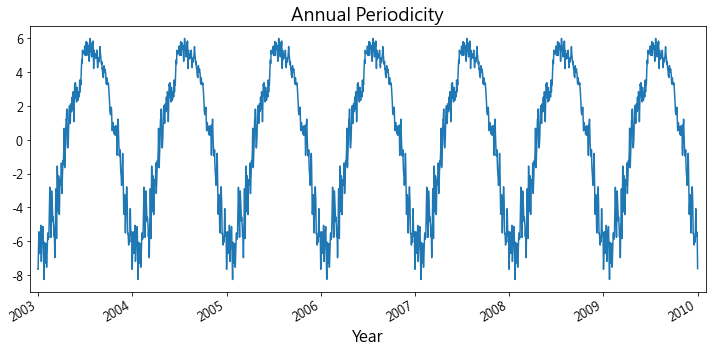

In [15]:
plt.figure(figsize=(10,5))
plt.title('Annual Periodicity')
Py.plot()
plt.xlim('2002-12-01 00', '2010-01-31 23')
plt.xlabel('Year')
plt.savefig('Figure1-D-1.png', dpi=360)

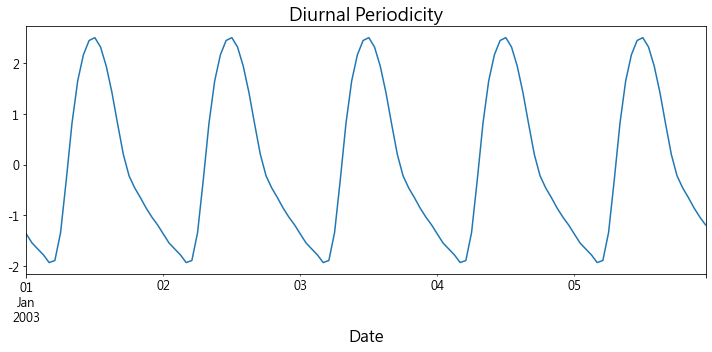

In [25]:
plt.figure(figsize=(10,5))
plt.title('Diurnal Periodicity')
Pd[:120].plot()
plt.xlabel('Date')
plt.savefig('Figure1-D-2.png', dpi=360)

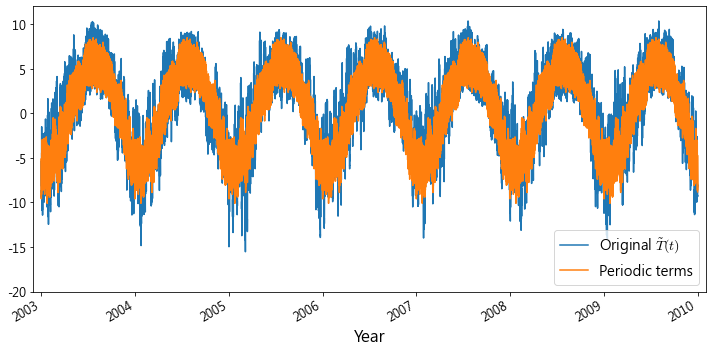

In [17]:
plt.figure(figsize=(10,5))
MeanTA.plot(label=r'Original $\tilde{T}(t)$')
(Py+Pd).plot(label='Periodic terms')
plt.xlim('2002-12-01 00', '2010-01-31 23')
plt.ylim(-20, 12)
plt.xlabel('Year')
plt.legend()
plt.savefig('Figure1-D-3.png', dpi=360)

In [31]:
false = FTest[FTest.Test==False].index
FTest = FTest.drop(labels=false).sort_values(by=['Squared'], ascending=False)
explainPerc = FTest['Variance'] / TotalVar * 100
FTest

,a,b,Squared,Variance,dof,Remainder,F,Crit,Test
0,-2.4173,-5.2356,33.254355,1.019579e+06,61317,422904.05389,73914.516122,4.605516,True
182,-0.9002,-1.8066,4.074411,1.249214e+05,61315,297982.612678,12852.357557,4.605516,True
183,0.0557,0.7159,0.515627,1.580913e+04,61313,282173.484964,1717.569331,4.605516,True
1,-0.2904,-0.4652,0.300736,9.220559e+03,61311,272952.925591,1035.566324,4.605516,True
4,-0.0853,-0.3063,0.101112,3.100080e+03,61309,269852.845452,352.160106,4.605516,True
...,...,...,...,...,...,...,...,...,...
121,-0.0086,-0.0372,0.001461,4.479288e+01,61123,235611.218992,5.810154,4.605517,True
84,-0.0216,-0.0288,0.001296,3.973348e+01,61121,235571.485511,5.154593,4.605517,True
137,0.0313,-0.0145,0.001188,3.643156e+01,61119,235535.053953,4.726813,4.605517,True
187,0.0265,0.0218,0.001174,3.600726e+01,61117,235499.046694,4.672324,4.605517,True


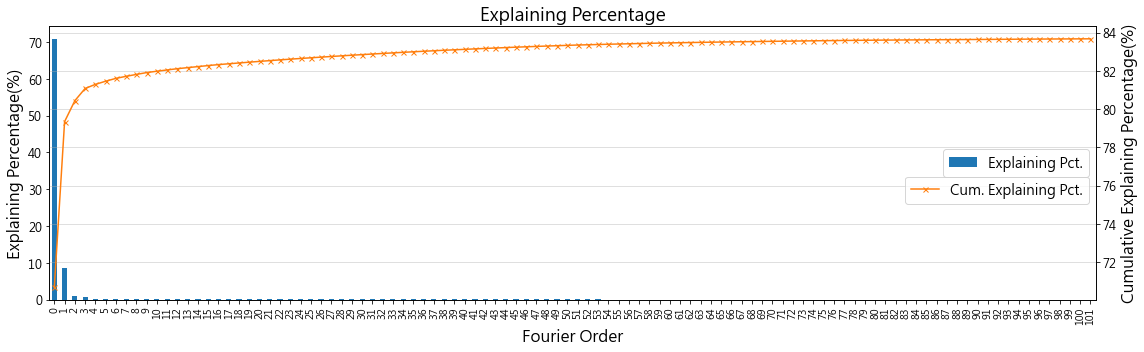

In [19]:
plt.rcParams['xtick.labelsize'] = 10
plt.figure(figsize=(16,5))
plt.title('Explaining Percentage')
plt.xlabel('Fourier Order')
plt.ylabel('Explaining Percentage(%)')
explainPerc.plot(kind='bar', use_index=False, label='Explaining Pct.')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.twinx()
plt.ylabel('Cumulative Explaining Percentage(%)')
explainPerc.cumsum().plot(use_index=False, marker='x', ms=5, color='C1', label='Cum. Explaining Pct.')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.4))
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figure1-D-4.png', dpi=360)
plt.rcParams['xtick.labelsize'] = 12

# 第二題

In [20]:
Z = Temp.sub(stnMean).sub(Py+Pd, axis=0)
Z

,板橋,淡水,鞍部,臺北,竹子湖,基隆,花蓮,蘇澳,宜蘭,高雄,嘉義,臺中,阿里山,大武,新竹,恆春,日月潭,臺東,梧棲
Time,,,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,0.468225,0.445135,-1.273350,0.192736,-1.314805,1.316881,2.590405,0.598636,0.527292,-1.425391,-2.435224,-0.959585,-0.426335,3.151292,-1.165301,3.396270,1.422750,2.018832,-1.054658
2003-01-01 01:00:00,0.256164,-0.066926,-1.185411,0.180675,-1.126866,1.304820,2.778345,0.686575,0.615231,-1.737451,-2.647285,-1.171646,0.061605,3.239232,-0.977362,3.284209,1.410690,1.606771,-0.966719
2003-01-01 02:00:00,0.182683,-0.340407,-1.158892,0.107194,-1.200347,1.631339,2.804863,1.013094,0.941750,-1.910933,-2.820766,-1.645127,0.388123,3.165750,-0.850843,3.210728,2.537208,1.733290,-1.040200
2003-01-01 03:00:00,0.104491,-2.518600,-1.137085,-0.070998,-1.178539,1.653147,2.926671,1.034902,0.463558,-2.089125,-2.898958,-2.123319,0.309931,3.087558,-0.729035,3.032536,2.259016,1.555097,-0.918392
2003-01-01 04:00:00,0.156658,-2.666432,-1.084917,-0.018831,-1.126372,1.905314,3.078839,1.187069,0.915725,-1.936957,-3.646791,-2.171152,0.362099,3.139726,-0.376868,2.984703,1.511184,1.607265,-0.666225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,-1.451683,-1.274773,-3.493258,-1.527172,-2.934713,-0.803027,-1.229503,-1.621272,-2.192616,1.154701,-1.855132,-1.979493,0.853757,1.331384,-1.485209,1.476362,3.302842,-1.601076,-1.674566
2009-12-31 20:00:00,-1.329790,-1.352880,-3.771365,-1.605279,-3.112820,-0.881133,-0.707609,-0.599379,-1.870722,1.376595,-1.833239,-1.957599,0.175651,1.253278,-1.263315,1.698255,1.524736,-1.179183,-1.452673
2009-12-31 21:00:00,-1.298274,-1.021364,-3.339849,-1.473763,-2.681304,-0.349617,-0.276093,-1.067863,-1.539206,1.008111,-1.701723,-1.926083,0.307167,1.984794,-1.331799,1.729771,0.856252,-0.747667,-1.121157


In [21]:
import pyflux as pf

In [22]:
model = pf.VAR(data=Z, lags=3)
x = model.fit(method='OLS')

In [23]:
x.summary()

VAR(3)                                                                                                    
======================================================= ==================================================
Dependent Variable: 板橋,淡水,鞍部,臺北,竹子湖,基隆,花蓮,蘇澳,宜蘭,高雄,嘉義,臺 Method: OLS                                       
Start Date: 2003-01-01 03:00:00                         Log Likelihood: nan                               
End Date: 2009-12-31 23:00:00                           AIC: nan                                          
Number of observations: 61317                           BIC: nan                                          
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
板橋 Constant                              -0.0       0.0023     -0.003   0.9976   (-0.0045 | 0.0045)       
板橋 AR(1)                             

In [24]:
idx = x.z.z_indices
idx

{'板橋 Constant': {'start': 0, 'end': 0},
 '板橋 AR(1)': {'start': 1, 'end': 1},
 '淡水 to 板橋 AR(1)': {'start': 2, 'end': 2},
 '鞍部 to 板橋 AR(1)': {'start': 3, 'end': 3},
 '臺北 to 板橋 AR(1)': {'start': 4, 'end': 4},
 '竹子湖 to 板橋 AR(1)': {'start': 5, 'end': 5},
 '基隆 to 板橋 AR(1)': {'start': 6, 'end': 6},
 '花蓮 to 板橋 AR(1)': {'start': 7, 'end': 7},
 '蘇澳 to 板橋 AR(1)': {'start': 8, 'end': 8},
 '宜蘭 to 板橋 AR(1)': {'start': 9, 'end': 9},
 '高雄 to 板橋 AR(1)': {'start': 10, 'end': 10},
 '嘉義 to 板橋 AR(1)': {'start': 11, 'end': 11},
 '臺中 to 板橋 AR(1)': {'start': 12, 'end': 12},
 '阿里山 to 板橋 AR(1)': {'start': 13, 'end': 13},
 '大武 to 板橋 AR(1)': {'start': 14, 'end': 14},
 '新竹 to 板橋 AR(1)': {'start': 15, 'end': 15},
 '恆春 to 板橋 AR(1)': {'start': 16, 'end': 16},
 '日月潭 to 板橋 AR(1)': {'start': 17, 'end': 17},
 '臺東 to 板橋 AR(1)': {'start': 18, 'end': 18},
 '梧棲 to 板橋 AR(1)': {'start': 19, 'end': 19},
 '板橋 AR(2)': {'start': 20, 'end': 20},
 '淡水 to 板橋 AR(2)': {'start': 21, 'end': 21},
 '鞍部 to 板橋 AR(2)': {'start': 22, 'end': 22